# The validate pipeline

The pipeline cross-validates the optimized predictive model (output of the `baseline` pipeline) and builds a conformal predictor to construct uncertainty intervals for the optimized model's predictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from eensight.utils import create_groups
from eensight.utils.jupyter import load_catalog
from eensight.pipelines.validate import (
    CrossValidator,
    AggregatedCp,
    create_splits,
)

## Cross-validation

The cross-validation process that is implemented in `eensight` is governed by four (4) parameters:

1. `group_by`: This parameter defines what constitutes an indivisible group of data. If its value is "day", the-cross validation process will consider the different days in the dataset as groups. If its value is "week", the different weeks in the dataset will be regarded as groups. In either case, the same group **will not** appear in two different folds. This is summarized schematically in the diagram below.

   <img src="images/group_by.png?modified=12345678" alt="grouped" width="600"/>


2. `stratify_by`: This parameter defines how the cross-validation process will stratify the folds. The default value is "month", which means that the folds will preserve the percentage of month occurrences across test sets. In other words, all the test sets will contain observations from all the months that can be found in the full dataset. Alternative values for `stratify_by` are "week" and None (for no stratification).

   This is summarized schematically in the diagram below.

   <img src="images/stratify_by.png?modified=12345678" alt="grouped" width="600"/>

3. `n_splits`: The number of folds. It must be at least 2. 


4. `n_repeats`: This parameter defines the number of times the cross-validation process should be repeated. 

   If we choose the number of folds to be five (5), we actually choose to estimate the model’s performance on unseen data as the mean of five (5) values. This is generally a low number of values and leads to a high variance of the result. The solution, however, is not to increase the number of folds, since this would decrease the size of the test sets and the extent to which they adequately represent the data. Instead, we repeat the cross-validation process and merge the results. 
   
   If we stratify over months, group by weeks and select the number of folds to be four (4), this roughly translates into test datasets that include one (1) week from each month. Given that each month has four (4) weeks, the possible number of week combinations that define a test set is very high. As a result, it is highly unlikely that repeating the cross-validation process a few times will lead to evaluating identical folds. Empirically four (4) repetitions of a cross-validation process with four (4) folds, i.e. 16 folds in total, is enough to provide stable performance estimations.

The combination of `group_by` and `stratify_by` allows the model to see data that covers all seasonality and operating mode patterns, while still making it non trivial for it to predict on unseen data.  

**Note**: We should not stratify the cross-validation folds if the model that we want to evaluate aims at forecasting. However, M&V models aim at interpolating the available data, and this makes stratification a suitable strategy.

### Load demo data

In [3]:
catalog = load_catalog('demo', partial_catalog=True)

In [4]:
data = catalog.load('train.model_input_data')

consumption_daily = data['consumption'].groupby(lambda x: x.date).sum()

2021-11-18 22:27:28,433 - kedro.io.data_catalog - INFO - Loading data from `train.model_input_data` (CSVDataSet)...


### Case: `group_by` is "day", no stratification

In [5]:
splits = create_splits(data, group_by='day', stratify_by=None, 
                       n_splits=3, n_repeats=1)

In [6]:
data_as_days = create_groups(data, 'day')

for train_idx, test_idx in splits(data):
    days_in_train = np.unique(data_as_days[train_idx])
    days_in_test = np.unique(data_as_days[test_idx])
    common_days = np.intersect1d(days_in_train, days_in_test)
    print('Common days between train and test splits: '
          f'{len(common_days) / data_as_days.nunique()}')

Common days between train and test splits: 0.0
Common days between train and test splits: 0.0
Common days between train and test splits: 0.0


We can visualize the data per split:

In [7]:
def visualize_splits(n_splits, splits, data, figsize=(12, 8)):
    colors = ['#d8b365', '#01665e']

    with plt.style.context('seaborn-whitegrid'):    
        fig = plt.figure(figsize=figsize, dpi=96)
        layout = (n_splits, 1)
        
        axes = []
        for i in range(n_splits):
            axes.append(plt.subplot2grid(layout, (i, 0)))
        
        for i, (train_idx, test_idx) in enumerate(splits(data)):
            subset = consumption_daily[
                        np.isin(consumption_daily.index, data.iloc[train_idx].index.date)
            ]

            subset.plot(ax=axes[i], color=colors[0], style='.', ms=8, alpha=0.8, 
                        label=f'split_{i}:train')

            subset = consumption_daily[
                        np.isin(consumption_daily.index, data.iloc[test_idx].index.date)
            ]

            subset.plot(ax=axes[i], color=colors[1], style='.', ms=8, alpha=0.8, 
                        label=f'split_{i}:test')

        for ax in axes:
            ax.legend(frameon=True, shadow=True, bbox_to_anchor=(1.01, 1.01))

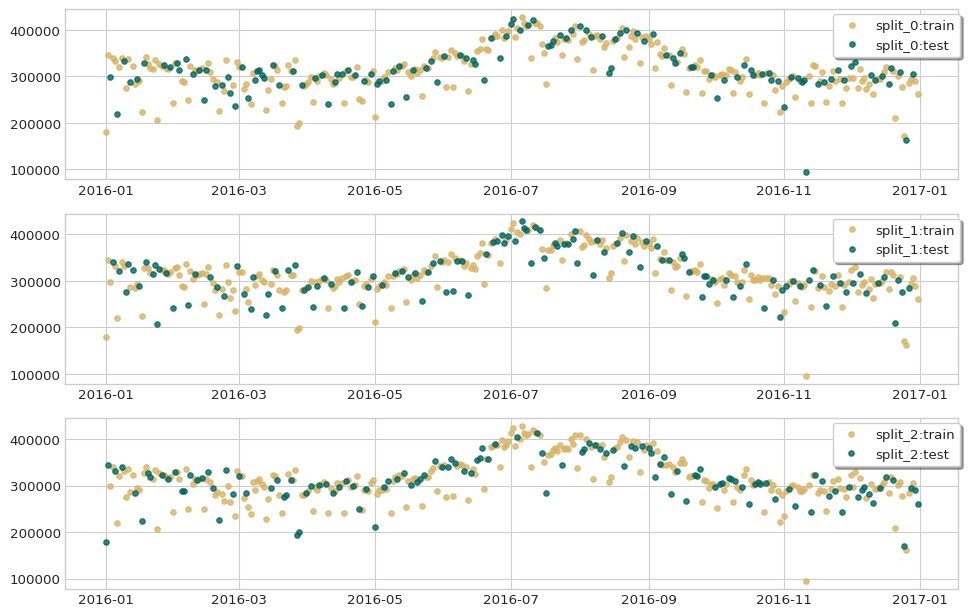

In [8]:
visualize_splits(3, splits, data, figsize=(12, 8))

### Case: `group_by` is "week", no stratification

In [9]:
splits = create_splits(data, 
                       group_by='week', 
                       stratify_by=None, 
                       n_splits=3, 
                       n_repeats=1
)

In [10]:
data_as_weeks = create_groups(data, 'week')

for train_idx, test_idx in splits(data):
    weeks_in_train = np.unique(data_as_weeks[train_idx])
    weeks_in_test = np.unique(data_as_weeks[test_idx])
    common_weeks = np.intersect1d(weeks_in_train, weeks_in_test)
    print('Common weeks between train and test splits: '
          f'{len(common_weeks) / data_as_weeks.nunique()}')

Common weeks between train and test splits: 0.0
Common weeks between train and test splits: 0.0
Common weeks between train and test splits: 0.0


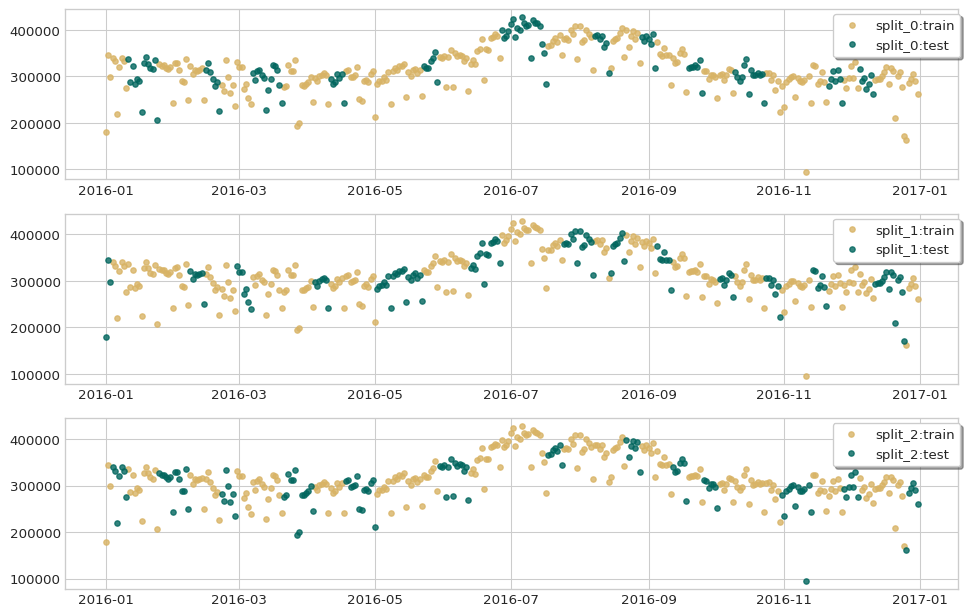

In [11]:
visualize_splits(3, splits, data, figsize=(12, 8))

### Case: `group_by` is "day", `stratify_by` is "week"

In [12]:
data_as_days = create_groups(data, 'day').to_frame('data_as_days')
data_as_weeks = create_groups(data, 'week').to_frame('data_as_weeks')
data_as_groups = pd.concat((data_as_days, data_as_weeks), axis=1)

Different values of `n_splits` lead to different stratification levels. In other words, the more splits we want to make, the more probable becomes that some weeks will not be represented in both train and test splits:

In [13]:
for n_splits in range(2, 10):
    splits = create_splits(data, group_by='day', stratify_by='week', 
                           n_splits=n_splits, n_repeats=1)
    
    for train_idx, test_idx in splits(data):
        all_values = []
        weeks_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_weeks'])
        weeks_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_weeks'])
        common_weeks = np.intersect1d(weeks_in_train, weeks_in_test)
        all_values.append(len(common_weeks) / data_as_groups["data_as_weeks"].nunique())
    print(f'n_splits: {n_splits}, average coverage: {np.mean(all_values)}')

n_splits: 2, average coverage: 1.0
n_splits: 3, average coverage: 1.0
n_splits: 4, average coverage: 0.9245283018867925
n_splits: 5, average coverage: 0.8490566037735849
n_splits: 6, average coverage: 0.7735849056603774
n_splits: 7, average coverage: 0.6981132075471698
n_splits: 8, average coverage: 0.660377358490566
n_splits: 9, average coverage: 0.6226415094339622


The grouping however is always maintained:

In [14]:
for n_splits in range(2, 10):
    splits = create_splits(data, group_by='day', stratify_by='week', 
                           n_splits=n_splits, n_repeats=1)
    
    for train_idx, test_idx in splits(data):
        all_values = []
        days_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_days'])
        days_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_days'])
        common_days = np.intersect1d(days_in_train, days_in_test)
        all_values.append(len(common_days) / data_as_groups["data_as_days"].nunique())
    print(f'n_splits: {n_splits}, common days between train and test splits: '
          f'{np.mean(all_values)}')

n_splits: 2, common days between train and test splits: 0.0
n_splits: 3, common days between train and test splits: 0.0
n_splits: 4, common days between train and test splits: 0.0
n_splits: 5, common days between train and test splits: 0.0
n_splits: 6, common days between train and test splits: 0.0
n_splits: 7, common days between train and test splits: 0.0
n_splits: 8, common days between train and test splits: 0.0
n_splits: 9, common days between train and test splits: 0.0


We can visualize the data per split:

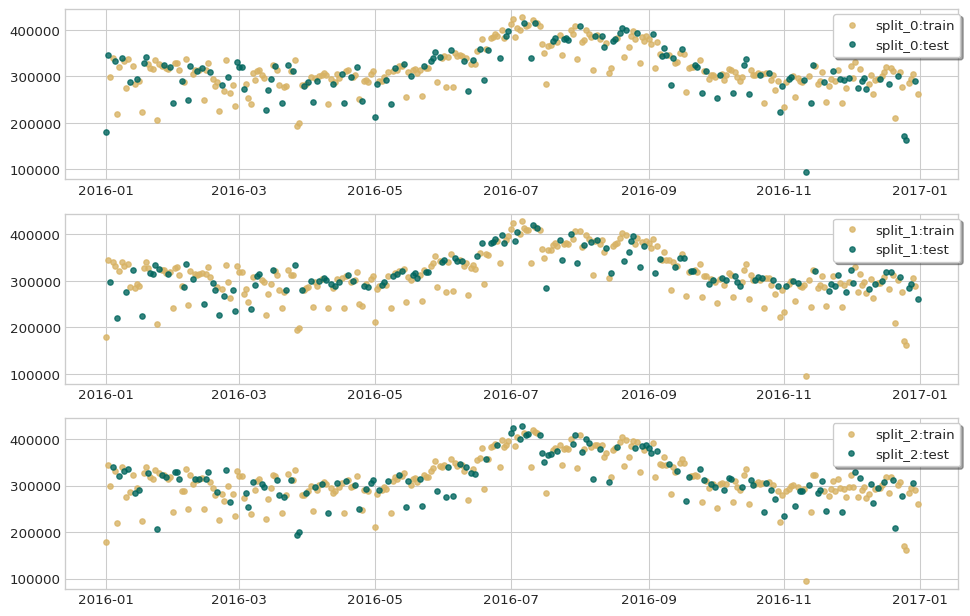

In [15]:
splits = create_splits(data, 
                       group_by='day', 
                       stratify_by='week', 
                       n_splits=3, 
                       n_repeats=1
)
    
visualize_splits(3, splits, data, figsize=(12, 8))

### Case: `group_by` is "week", `stratify_by` is "month"

In [16]:
data_as_weeks = create_groups(data, 'week').to_frame('data_as_weeks')
data_as_months = create_groups(data, 'month').to_frame('data_as_months')
data_as_groups = pd.concat((data_as_weeks, data_as_months), axis=1)

Different values of `n_splits` lead to different stratification levels:

In [17]:
for n_splits in range(2, 10):
    splits = create_splits(data, group_by='week', stratify_by='month', 
                           n_splits=n_splits, n_repeats=1)

    for train_idx, test_idx in splits(data):
        all_values = []
        months_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_months'])
        months_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_months'])
        common_months = np.intersect1d(months_in_train, months_in_test)
        all_values.append(len(common_months) / data_as_groups["data_as_months"].nunique())
    print(f'n_splits: {n_splits}, average coverage: {np.mean(all_values)}')

n_splits: 2, average coverage: 0.9166666666666666
n_splits: 3, average coverage: 0.9166666666666666
n_splits: 4, average coverage: 0.9166666666666666
n_splits: 5, average coverage: 0.5833333333333334
n_splits: 6, average coverage: 0.75
n_splits: 7, average coverage: 0.5833333333333334
n_splits: 8, average coverage: 0.4166666666666667
n_splits: 9, average coverage: 0.5


The grouping however is always maintained:

In [18]:
for n_splits in range(2, 10):
    splits = create_splits(data, group_by='week', stratify_by='month', 
                           n_splits=n_splits, n_repeats=1)
    for train_idx, test_idx in splits(data):
        all_values = []
        weeks_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_weeks'])
        weeks_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_weeks'])
        common_weeks = np.intersect1d(weeks_in_train, weeks_in_test)
        all_values.append(len(common_weeks) / data_as_groups["data_as_weeks"].nunique())
    print(f'n_splits: {n_splits}, common weeks between train and test splits: '
          f'{np.mean(all_values)}')

n_splits: 2, common weeks between train and test splits: 0.0
n_splits: 3, common weeks between train and test splits: 0.0
n_splits: 4, common weeks between train and test splits: 0.0
n_splits: 5, common weeks between train and test splits: 0.0
n_splits: 6, common weeks between train and test splits: 0.0
n_splits: 7, common weeks between train and test splits: 0.0
n_splits: 8, common weeks between train and test splits: 0.0
n_splits: 9, common weeks between train and test splits: 0.0


We can visualize the data per split:

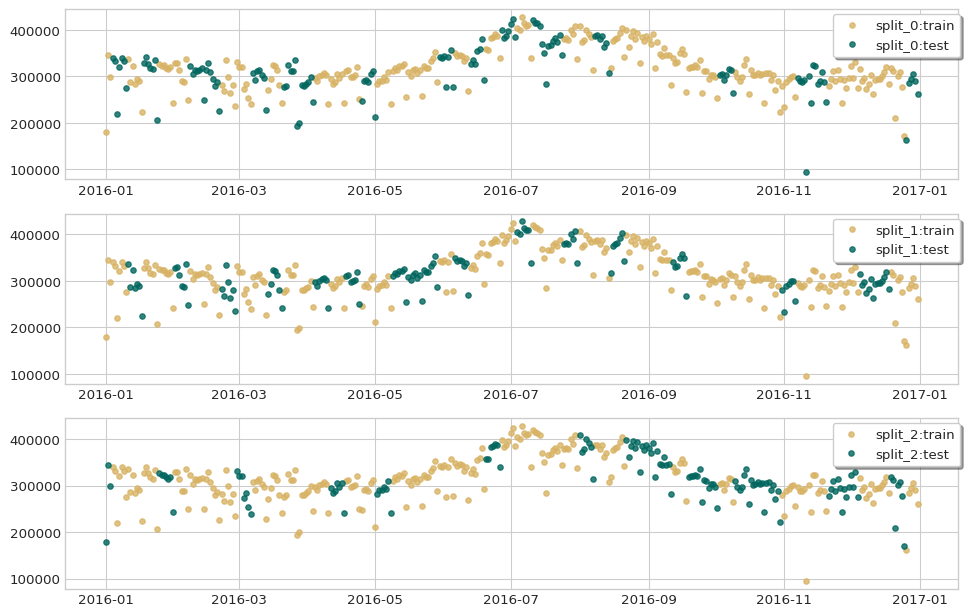

In [19]:
splits = create_splits(data, 
                       group_by='week', 
                       stratify_by='month', 
                       n_splits=3, 
                       n_repeats=1
)
visualize_splits(3, splits, data, figsize=(12, 8))

### Case: `group_by` is "day", `stratify_by` is "month"

In [20]:
data_as_days = create_groups(data, 'day').to_frame('data_as_days')
data_as_months = create_groups(data, 'month').to_frame('data_as_months')
data_as_groups = pd.concat((data_as_days, data_as_months), axis=1)

Since we have a sufficient number of unique days per month, different values of `n_splits` do not affect stratification levels (unless we ask for a very high number of splits):

In [21]:
for n_splits in range(2, 10):
    splits = create_splits(data, group_by='day', stratify_by='month', 
                           n_splits=n_splits, n_repeats=1)
    
    for train_idx, test_idx in splits(data):
        all_values = []
        months_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_months'])
        months_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_months'])
        common_months = np.intersect1d(months_in_train, months_in_test)
        all_values.append(len(common_months) / data_as_groups["data_as_months"].nunique())
    print(f'n_splits: {n_splits}, average coverage: {np.mean(all_values)}')

n_splits: 2, average coverage: 1.0
n_splits: 3, average coverage: 1.0
n_splits: 4, average coverage: 1.0
n_splits: 5, average coverage: 1.0
n_splits: 6, average coverage: 1.0
n_splits: 7, average coverage: 1.0
n_splits: 8, average coverage: 1.0
n_splits: 9, average coverage: 1.0


.. and again:

In [22]:
for n_splits in range(2, 10):
    splits = create_splits(data, group_by='day', stratify_by='month', 
                           n_splits=n_splits, n_repeats=1)
    for train_idx, test_idx in splits(data):
        all_values = []
        days_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_days'])
        days_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_days'])
        common_days = np.intersect1d(days_in_train, days_in_test)
        all_values.append(len(common_days) / data_as_groups["data_as_days"].nunique())
    print(f'n_splits: {n_splits}, common days between train and test splits: '
          f'{np.mean(all_values)}')

n_splits: 2, common days between train and test splits: 0.0
n_splits: 3, common days between train and test splits: 0.0
n_splits: 4, common days between train and test splits: 0.0
n_splits: 5, common days between train and test splits: 0.0
n_splits: 6, common days between train and test splits: 0.0
n_splits: 7, common days between train and test splits: 0.0
n_splits: 8, common days between train and test splits: 0.0
n_splits: 9, common days between train and test splits: 0.0


We can visualize the data per split:

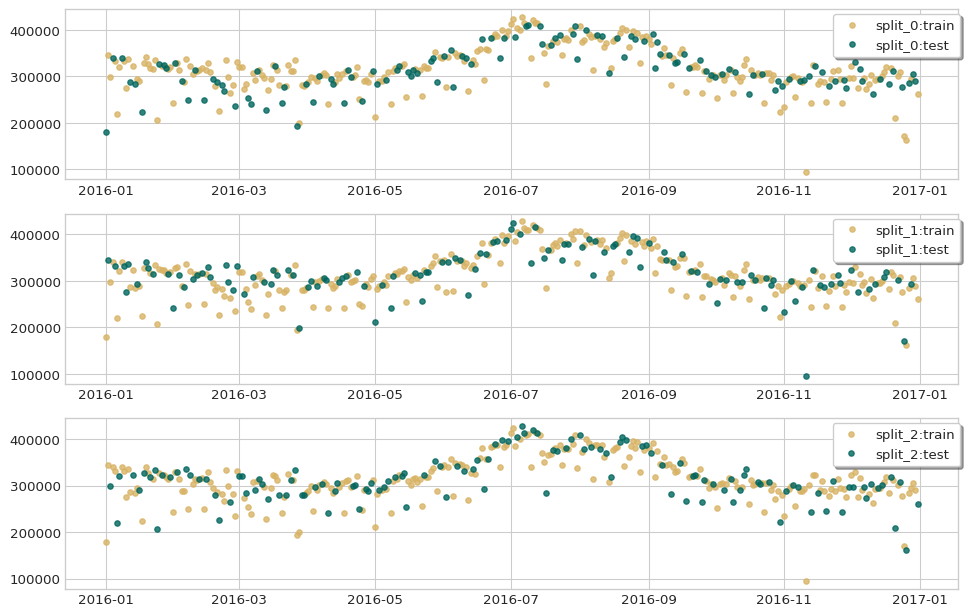

In [23]:
splits = create_splits(data, 
                       group_by='day', 
                       stratify_by='month', 
                       n_splits=3, 
                       n_repeats=1
)

visualize_splits(3, splits, data, figsize=(12, 8))

### Case: `group_by` is "week", `stratify_by` is "month", `n_repeats`>0

The combination `group_by='week'` and `stratify_by='month'` is the default in `eensight`.

The default value for `n_splits` is 3. If one wants to apply the train/test cycle to more splits, it is advisable to increase the `n_repeats` parameter:

In [24]:
data_as_weeks = create_groups(data, 'week').to_frame('data_as_weeks')
data_as_months = create_groups(data, 'month').to_frame('data_as_months')
data_as_groups = pd.concat((data_as_weeks, data_as_months), axis=1)

In [25]:
for n_repeats in range(1, 10):
    splits = create_splits(data, group_by='week', stratify_by='month', 
                           n_splits=3, n_repeats=n_repeats)
    for i, (train_idx, test_idx) in enumerate(splits(data)):
        all_values = []
        months_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_months'])
        months_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_months'])
        common_months = np.intersect1d(months_in_train, months_in_test)
        all_values.append(len(common_months) / data_as_groups["data_as_months"].nunique())
    print(f'n_repeats: {n_repeats}, total splits: {i+1}, average coverage: '
          f'{np.mean(all_values)}')

n_repeats: 1, total splits: 3, average coverage: 1.0
n_repeats: 2, total splits: 6, average coverage: 0.9166666666666666
n_repeats: 3, total splits: 9, average coverage: 1.0
n_repeats: 4, total splits: 12, average coverage: 0.9166666666666666
n_repeats: 5, total splits: 15, average coverage: 0.9166666666666666
n_repeats: 6, total splits: 18, average coverage: 1.0
n_repeats: 7, total splits: 21, average coverage: 1.0
n_repeats: 8, total splits: 24, average coverage: 1.0
n_repeats: 9, total splits: 27, average coverage: 0.9166666666666666


The grouping requirement is still maintained:

In [26]:
for n_repeats in range(1, 10):
    splits = create_splits(data, group_by='week', stratify_by='month', 
                           n_splits=3, n_repeats=n_repeats)
    for i, (train_idx, test_idx) in enumerate(splits(data)):
        all_values = []
        weeks_in_train = np.unique(data_as_groups.iloc[train_idx]['data_as_weeks'])
        weeks_in_test = np.unique(data_as_groups.iloc[test_idx]['data_as_weeks'])
        common_weeks = np.intersect1d(weeks_in_train, weeks_in_test)
        all_values.append(len(common_weeks) / data_as_groups["data_as_weeks"].nunique())
    print(f'n_repeats: {n_repeats}, total splits: {i+1}, common weeks between train and '
          f'test splits: {np.mean(all_values)}')

n_repeats: 1, total splits: 3, common weeks between train and test splits: 0.0
n_repeats: 2, total splits: 6, common weeks between train and test splits: 0.0
n_repeats: 3, total splits: 9, common weeks between train and test splits: 0.0
n_repeats: 4, total splits: 12, common weeks between train and test splits: 0.0
n_repeats: 5, total splits: 15, common weeks between train and test splits: 0.0
n_repeats: 6, total splits: 18, common weeks between train and test splits: 0.0
n_repeats: 7, total splits: 21, common weeks between train and test splits: 0.0
n_repeats: 8, total splits: 24, common weeks between train and test splits: 0.0
n_repeats: 9, total splits: 27, common weeks between train and test splits: 0.0


### Apply cross-validation

Load the optimized model:

In [27]:
model = catalog.load('mean_model')

2021-11-18 22:28:57,848 - kedro.io.data_catalog - INFO - Loading data from `mean_model` (PickleDataSet)...
2021-11-18 22:28:59,243 - numba.cuda.cudadrv.driver - INFO - init


Split the training data:

In [28]:
# We train the predictive models without outliers:
X_train = data.loc[~data['consumption_outlier']].drop(
            ['consumption', 'consumption_outlier'], axis=1
          )
y_train = data.loc[X_train.index, ['consumption']]

In [29]:
cv_model = CrossValidator(
                model, 
                group_by="week",
                stratify_by="month",
                n_splits=3,
                n_repeats=5, 
                keep_estimators=True, 
                n_jobs=-1, 
                verbose=False
)

In [30]:
%%time
cv_model = cv_model.fit(X_train, y_train)

Wall time: 1min 21s


The `CrossValidator` contains the cross-validation scores: 

In [31]:
cv_model.scores_

{'CVRMSE': array([0.15691343, 0.15326497, 0.14561331, 0.1573687 , 0.15607067,
        0.14104361, 0.15294346, 0.14293931, 0.1603994 , 0.15248599,
        0.13499399, 0.17341842, 0.14853832, 0.16873316, 0.13746435]),
 'NMBE': array([-0.00147821, -0.00273611, -0.01308307, -0.00463683, -0.01833051,
         0.00507181, -0.02354457,  0.01599045, -0.00852519,  0.01126879,
        -0.01148739, -0.02452911,  0.00119291, -0.01892827, -0.00686278])}

In [32]:
print(f'Mean out-of-sample CVRMSE (%): {np.mean(cv_model.scores_["CVRMSE"])*100}')
print(f'Mean out-of-sample NMBE: (%) {np.mean(cv_model.scores_["NMBE"])*100}')

Mean out-of-sample CVRMSE (%): 15.214607210383674
Mean out-of-sample NMBE: (%) -0.6707871909697503


### Save to the catalog

In [33]:
catalog.save('cv_model', cv_model)

2021-11-18 22:30:30,752 - kedro.io.data_catalog - INFO - Saving data to `cv_model` (PickleDataSet)...


## Learning the uncertainty intervals

Suppose we have a training dataset $(X_i,Y_i) \in R^d×R$, $i=1,..,n$, and a new test point $(X_{n+1},Y_{n+1})$ drawn from the same distribution. If we have a regression model $\hat{\mu}$  that has been fitted on the training data, we can apply it on the new test point’s features to get a prediction for the target $\hat{Y}_{n+1}=\hat{\mu}(X_{n+1})$. 

In addition, we want a prediction interval for the test point, i.e. an interval around $\hat{\mu}(X_{n+1})$  that is likely to contain the true value of $Y_{n+1}$. If the desired miscoverage rate is $a$ (or alternatively, the desired confidence level for the interval is $1-a$), this goal can be stated as find:

$$C_a(X_{n+1}):  P\{Y_{n+1} \in C_a(X_{n+1} ) \} \geq 1-a$$


`eensight` uses [conformal prediction](https://arxiv.org/abs/2107.07511) for distribution-free uncertainty quantification. 

The method builds upon the cross-validation functionality. If `CrossValidator` is instantiated with `keep_estimators=True`, we get: (a) a set of estimators, each of which has been fitted on a subset of the data, and (b) the index of the data subset that each estimator did not see during fitting. 

More formally, during cross-validation, we can split the training dataset into $K$ subsets $S_1,…,S_K$, and define $\hat{\mu}_{/S_k}$ as a regression model that has been fitted onto the training data with the $k$-th subset removed. `CrossValidator` stores each model $\hat{\mu}_{/S_k}$ (in attribute `estimators`) alongside with a mapping of the form $S_k(i) \rightarrow \hat{\mu}_{/S_k}$ (in attribute `oos_masks`, here *oos* stands for out-of-sample), where $S_k(i)$ identifies the subset that contains the observation $X_i$.

Conformal estimation uses the non-conformity scores defined as:

<img src="images/conformal_01.png?modified=12345678" alt="grouped" width="500"/>

Then, the conformal prediction interval is defined as:

<img src="images/conformal_02.png?modified=1234567" alt="grouped" width="700"/>

where $q_{n,a}^+ (e_i)$ is the $\lceil(1-a)(n+1)\rceil$-th smallest value of $e_i$

The conformal prediction functionality of `eensight` resides in:

- `eensight.pipelines.validate.IcpEstimator`: [Inductive conformal estimator](https://link.springer.com/article/10.1007/s10994-013-5355-6)
- `eensight.pipelines.validate.AggregatedCp`: Aggregated conformal estimator. Combines multiple IcpRegressor estimators into an aggregated model.

First, create a conformal predictor <ins>without a normalizer</ins>:

In [34]:
conformal = AggregatedCp(
                estimators=cv_model.estimators, 
                oos_masks=cv_model.oos_masks,
                add_normalizer=False,
                n_jobs=-1
)


> **_NOTE:_** The conformal predictor must be fitted on the **same dataset** that was used for cross-validation


In [35]:
%%time
conformal = conformal.fit(X_train, y_train)

Wall time: 27.4 s


The `predict` function of `AggregatedCp` can be applied on any dataset for which we want uncertainty intervals, and it requires a `significance` parameter:

    significance : float or list of floats between 0 and 1
        Significance level (maximum allowed error rate) of predictions. If ``None``,
        then intervals for all significance levels (0.01, 0.02, ..., 0.99) will be
        computed.

In [36]:
%%time
pred_conf = conformal.predict(X_train, significance=[0.9, 0.95])

Wall time: 696 ms


The result of the `predict` method is a dataframe of shape `(len(X), len(significance))` with columns containing the significance levels used in the calculations, and data containing the quantiles of the non-conformity scores:

In [37]:
pred_conf.head()

,0.90,0.95
timestamp,,
2016-01-01 00:00:00,766.682639,990.153459
2016-01-01 00:15:00,766.682639,990.153459
2016-01-01 00:30:00,766.682639,990.153459
2016-01-01 00:45:00,766.682639,990.153459
2016-01-01 01:00:00,766.682639,990.153459


We can get a prediction for the mean:

In [38]:
%%time
prediction = model.predict(X_train)

Wall time: 7.05 s


... and add uncertainty intervals:

In [39]:
s = 0.9

intervals = pd.concat(
 ( (prediction['consumption'] + pred_conf[s]).to_frame('consumption_high'),
   (prediction['consumption'] - pred_conf[s]).to_frame('consumption_low')
 ), axis=1)

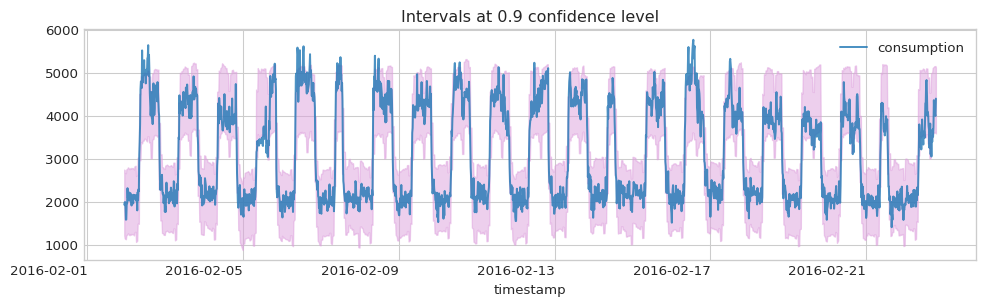

In [41]:
size=2000
title=f'Intervals at {s} confidence level'
start = np.random.randint(0, high=len(intervals)-size)
    
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    ax.fill_between(intervals.index[start:start+size], 
                    intervals['consumption_low'][start:start+size],
                    intervals['consumption_high'][start:start+size],
                    color='#DDA0DD', alpha=0.5
    )
    y_train.loc[intervals.index][start:start+size].plot(ax=ax, alpha=0.8, rot=0)
    ax.set_title(title)

`eensight` includes two metrics for evaluating the uncertainty intervals:

- Prediction Interval Coverage Probability (PICP). Computes the fraction of samples for
    which the ground truth lies within predicted interval.
- Mean Prediction Interval Width (MPIW). Computes the average width of the the prediction
    intervals. Measures the sharpness of intervals.

In [42]:
from eensight.pipelines.validate import mpiw, picp

In [43]:
print(f"Significance level: {s}")
print("Prediction Interval Coverage Probability (PICP): "
      f"{picp(y_train, intervals['consumption_low'], intervals['consumption_high'])}"
)
print("Mean Prediction Interval Width (MPIW): "
      f"{mpiw(intervals['consumption_low'], intervals['consumption_high'])}"
)

Significance level: 0.9
Prediction Interval Coverage Probability (PICP): 0.9308390347236137
Mean Prediction Interval Width (MPIW): 1533.365277703552


Next, create a conformal predictor <ins>with a normalizer</ins>. Its predictions act as a multiplicative correction factor of the non-conformity scores.

In [44]:
conformal = AggregatedCp(
                estimators=cv_model.estimators, 
                oos_masks=cv_model.oos_masks,
                add_normalizer=True,
                max_samples=0.8,
                n_jobs=-1
)

In [45]:
%%time

conformal = conformal.fit(X_train, y_train)
pred_conf = conformal.predict(X_train, significance=[0.90, 0.95])

Wall time: 31.3 s


In [46]:
s = 0.9

intervals = pd.concat(
 ( (prediction['consumption'] + pred_conf[s]).to_frame('consumption_high'),
   (prediction['consumption'] - pred_conf[s]).to_frame('consumption_low')
 ), axis=1)

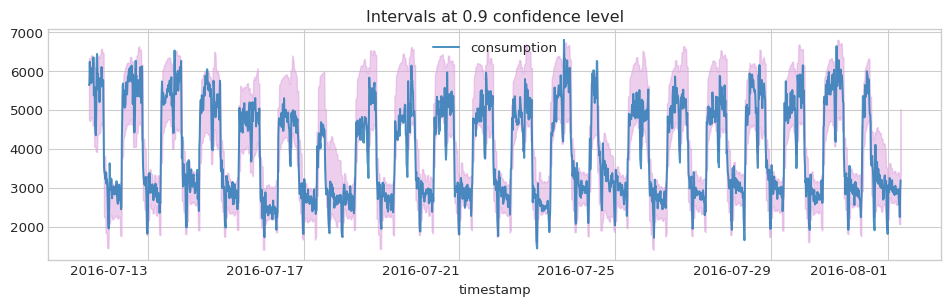

In [47]:
size=2000
title=f'Intervals at {s} confidence level'
start = np.random.randint(0, high=len(intervals)-size)
    
with plt.style.context('seaborn-whitegrid'):    
    fig = plt.figure(figsize=(12, 3.54), dpi=96)
    layout = (1, 1)
    ax = plt.subplot2grid(layout, (0, 0))

    ax.fill_between(intervals.index[start:start+size], 
                    intervals['consumption_low'][start:start+size],
                    intervals['consumption_high'][start:start+size],
                    color='#DDA0DD', alpha=0.5
    )
    y_train.loc[intervals.index][start:start+size].plot(ax=ax, alpha=0.8, rot=0)
    ax.set_title(title)

A normalizer provides similar coverage with narrower intervals:

In [48]:
print(f"Significance level: {s}")
print("Prediction Interval Coverage Probability (PICP): "
      f"{picp(y_train, intervals['consumption_low'], intervals['consumption_high'])}"
)
print("Mean Prediction Interval Width (MPIW): "
      f"{mpiw(intervals['consumption_low'], intervals['consumption_high'])}"
)

Significance level: 0.9
Prediction Interval Coverage Probability (PICP): 0.9312684281338562
Mean Prediction Interval Width (MPIW): 1424.1583593725702


### Save to the catalog

In [49]:
catalog.save('conformal_model', conformal)

2021-11-18 22:33:37,665 - kedro.io.data_catalog - INFO - Saving data to `conformal_model` (PickleDataSet)...


------------